<h1>BIEN3310 Project</h1>

In [23]:
#Imports
import scipy.io
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA, KernelPCA
from sklearn import svm

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

<h2>Preprocessing</h2>

In [24]:
#Format data from .mat
mat = scipy.io.loadmat('ELEC3810_Final_project.mat')

testSpike = pd.DataFrame(mat['testSpike'])
trainSpike = pd.DataFrame(mat['trainSpike'])
trainState = pd.DataFrame(mat['trainState'])

#Remove NaN
nonNanLabels = trainState.isna().any() == False

trainSpikeN = trainSpike.loc[:, nonNanLabels]
trainStateN = trainState.loc[:, nonNanLabels]
trainSpikeN.columns = range(trainSpikeN.columns.size)
trainStateN.columns = range(trainStateN.columns.size)

<IPython.core.display.Javascript object>


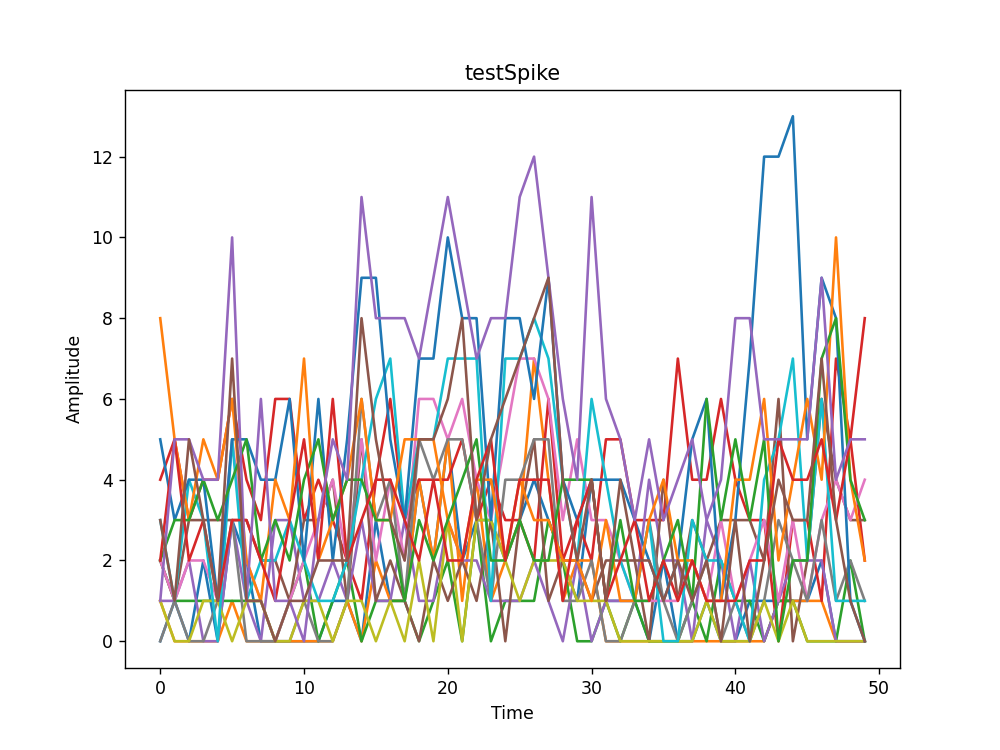

<IPython.core.display.Javascript object>


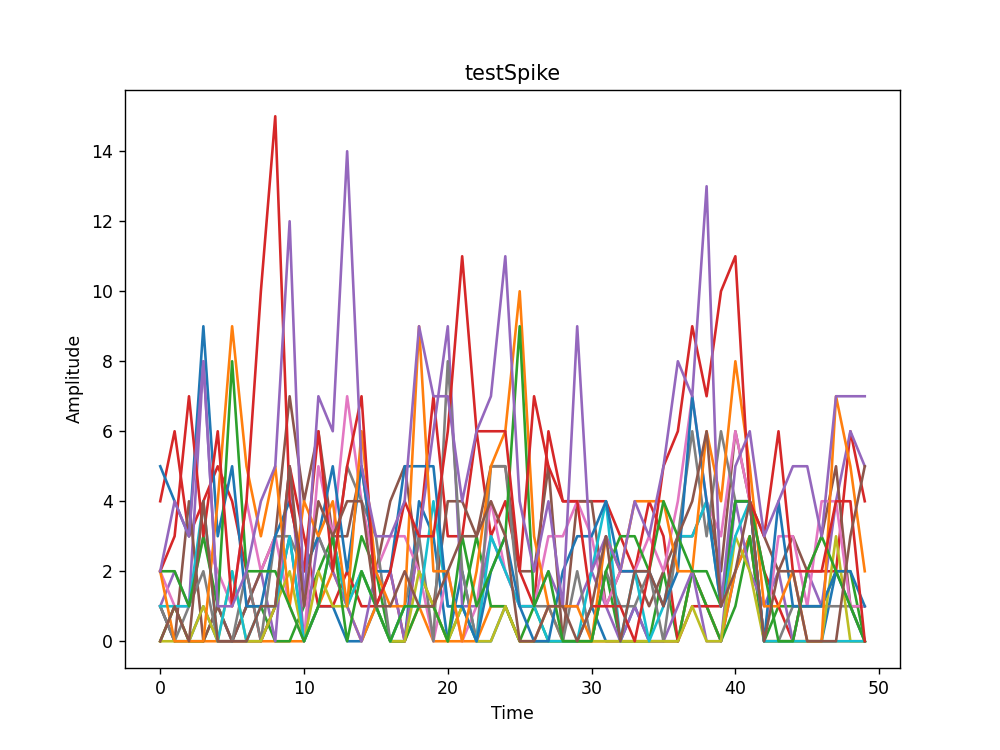

<IPython.core.display.Javascript object>


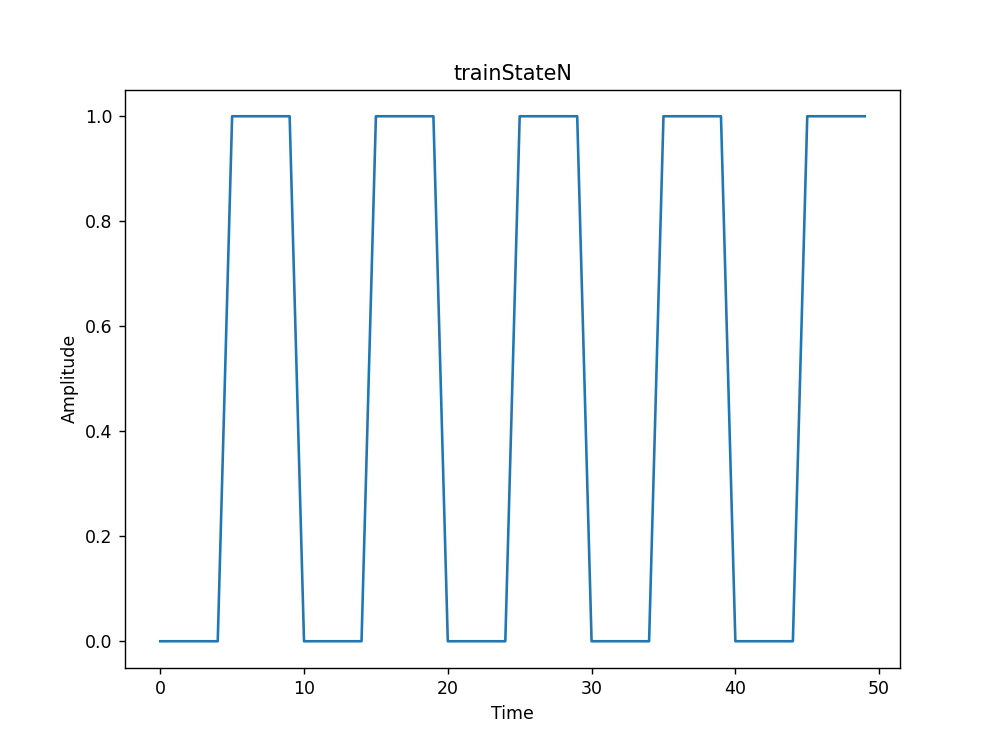

In [25]:
#Display some data
plt.figure(figsize=(8, 6))
plt.plot(testSpike.T[:50])
plt.title('testSpike')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(trainSpikeN.T[:50])
plt.title('testSpike')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(trainStateN.T[:50])
plt.title('trainStateN')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [26]:
#Split data
Train_indices = int(0.7 * len(trainSpikeN.T))
Val_indices = int(0.9 * len(trainSpikeN.T))
Test_indices = int(1 * len(trainSpikeN.T))

trainSpikeNTrain = trainSpikeN.T[:Train_indices].T
trainSpikeNVal = trainSpikeN.T[Train_indices:Val_indices].T
trainSpikeNTest = trainSpikeN.T[Val_indices:Test_indices].T

trainStateNTrain = trainStateN.to_numpy()[0, :Train_indices]
trainStateNVal = trainStateN.to_numpy()[0, Train_indices:Val_indices]
trainStateNTest = trainStateN.to_numpy()[0, Val_indices:Test_indices]

<H2>Data Checking</H2>

In [27]:
#PCA helper
def doPCA(X, kernel = None, dimension = 2):
    
    #PCA
    if kernel == None:
        pcaReduced = PCA(n_components=dimension)
        pcaData = pcaReduced.fit_transform(X)
    else:
        pass
    
    return pcaData, pcaReduced

    
def plotModel(X, title = '', y = None, boundary = None, sizeOfFig = (10, 8), Xval = [None], yval = [None], ax = None):
    if ax == None:
        ax = plt
        verbose = True
        fig = ax.figure(figsize=sizeOfFig)
    else:
        verbose = False
    
    if boundary != None:
        # Plot the decision boundary
        xx, yy = np.meshgrid(np.linspace(np.min(X), np.max(X), 200), np.linspace(np.min(X), np.max(X), 200))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        
        Z = Z.reshape(xx.shape)
        
        ax.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    #Plot points
    if y.any() != None:
        #Plot colours
        colors = ['red', 'blue', 'purple', 'green']
        labels = ['0', '1', '0 unseen', '1 unseen']
        for i in range(2):
            ax.scatter(X[y == i, 0], X[y == i, 1],\
                        label=labels[i], color=colors[i])
            
        if None not in yval and None not in Xval:
            #Plot unseen data
            for i in range(2):
                ax.scatter(Xval[yval == i, 0], Xval[yval == i, 1],\
                            label=labels[i+2], color=colors[i+2])
    else:
        ax.scatter(pcaData[:, 0], pcaData[:, 1])

    if verbose:
        plt.title(title)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.show()
    else:
        return ax
    

def plotModel3D(X, title, y = None, boundary = None, sizeOfFig = (10, 8), Xval = [None], yval = [None]):
    fig = plt.figure(figsize=sizeOfFig)
    ax = fig.add_subplot(111, projection='3d')
    
    if boundary != None:
        # Plot the decision boundary
        a,b,c = boundary.coef_[0]
        xx,yy = np.meshgrid(np.linspace(np.min(X), np.max(X), 200), np.linspace(np.min(X), np.max(X), 200))

        # Flatten the grid into 1D arrays
        x_flat = xx.flatten()
        y_flat = yy.flatten()

        # Compute the corresponding Z values for the linear plane
        z_predicted = a * x_flat + b * y_flat + c

        # Reshape the predicted Z values to the shape of the original grid
        zz = z_predicted.reshape(xx.shape)
        
        ax.plot_surface(xx, yy, zz, alpha=0.5, cmap='viridis')
        
    #plot points
    if y.any() != None:
        #Plot colours
        colors = ['red', 'blue', 'purple', 'green']
        labels = ['0', '1', '0 unseen', '1 unseen']
        for i in range(2):
            ax.scatter(X[y == i, 0], X[y == i, 1], pcaData[y == i, 2],\
                        label=labels[i], color=colors[i])
            
        if None not in yval and None not in Xval:
            #Plot unseen data
            for i in range(2):
                ax.scatter(Xval[yval == i, 0], Xval[yval == i, 1], Xval[yval == i, 2],\
                            label=labels[i+2], color=colors[i+2])
    else:
        ax.scatter(trainSpikeN_3D[trainStateN.to_numpy()[0] == i, 0], trainSpikeN_3D[trainStateN.to_numpy()[0] == i, 1],\
                    trainSpikeN_3D[trainStateN.to_numpy()[0] == i, 2], label=[i], color=colors[i])
    
    ax.set_title(title)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')

    plt.show()

<IPython.core.display.Javascript object>


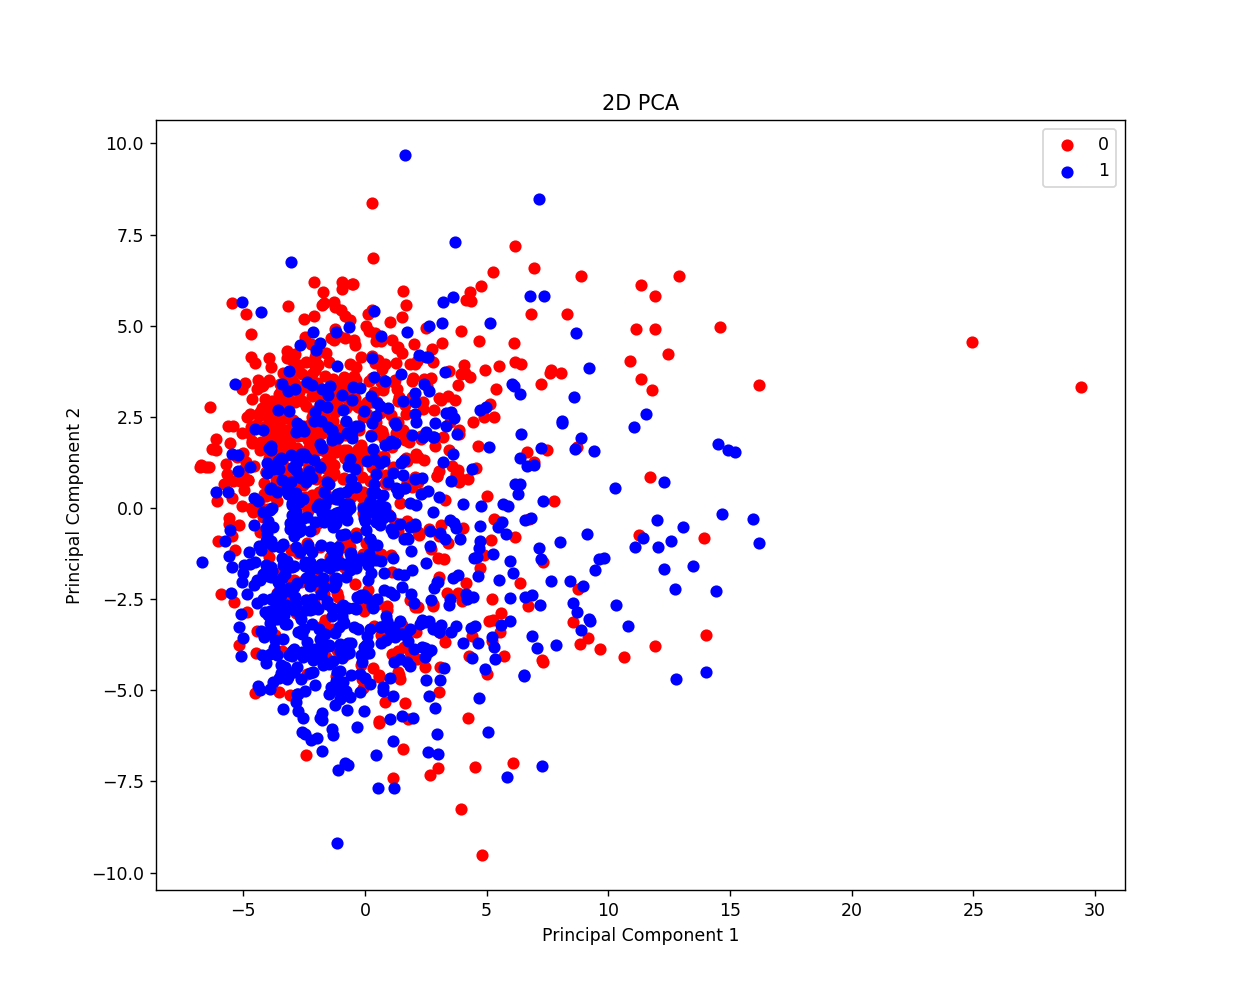

In [28]:
#PCA reduce to 2 dimensions
X1 = trainSpikeN.T
y1 = trainStateN.to_numpy()[0]
pcaData, pcaReduced = doPCA(X1, dimension = 2)
plotModel(pcaData, '2D PCA', y = y1)

<IPython.core.display.Javascript object>


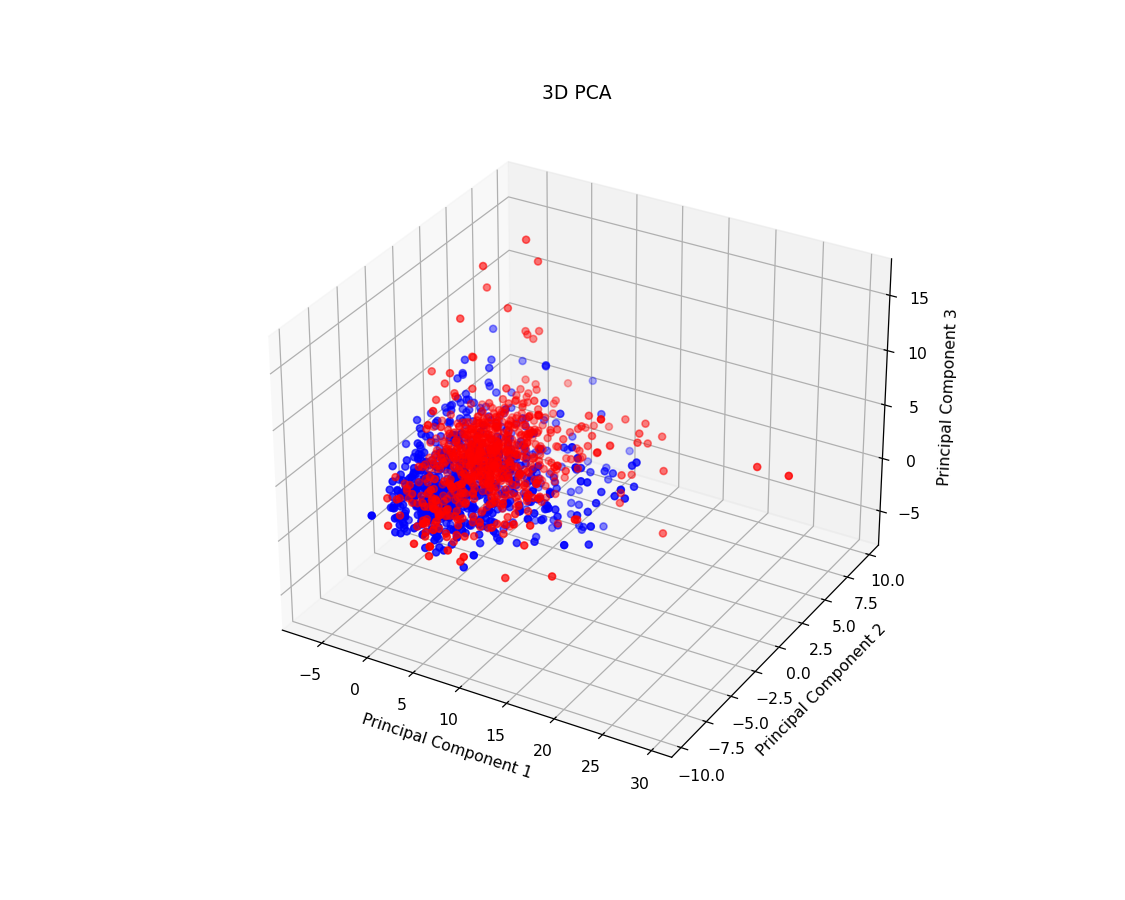

In [29]:
#PCA reduce to 3 dimensions
X1 = trainSpikeN.T
y1 = trainStateN.to_numpy()[0]
pcaData, pcaReduced = doPCA(X1, dimension = 3)
plotModel3D(pcaData, '3D PCA', y = y1)

<IPython.core.display.Javascript object>


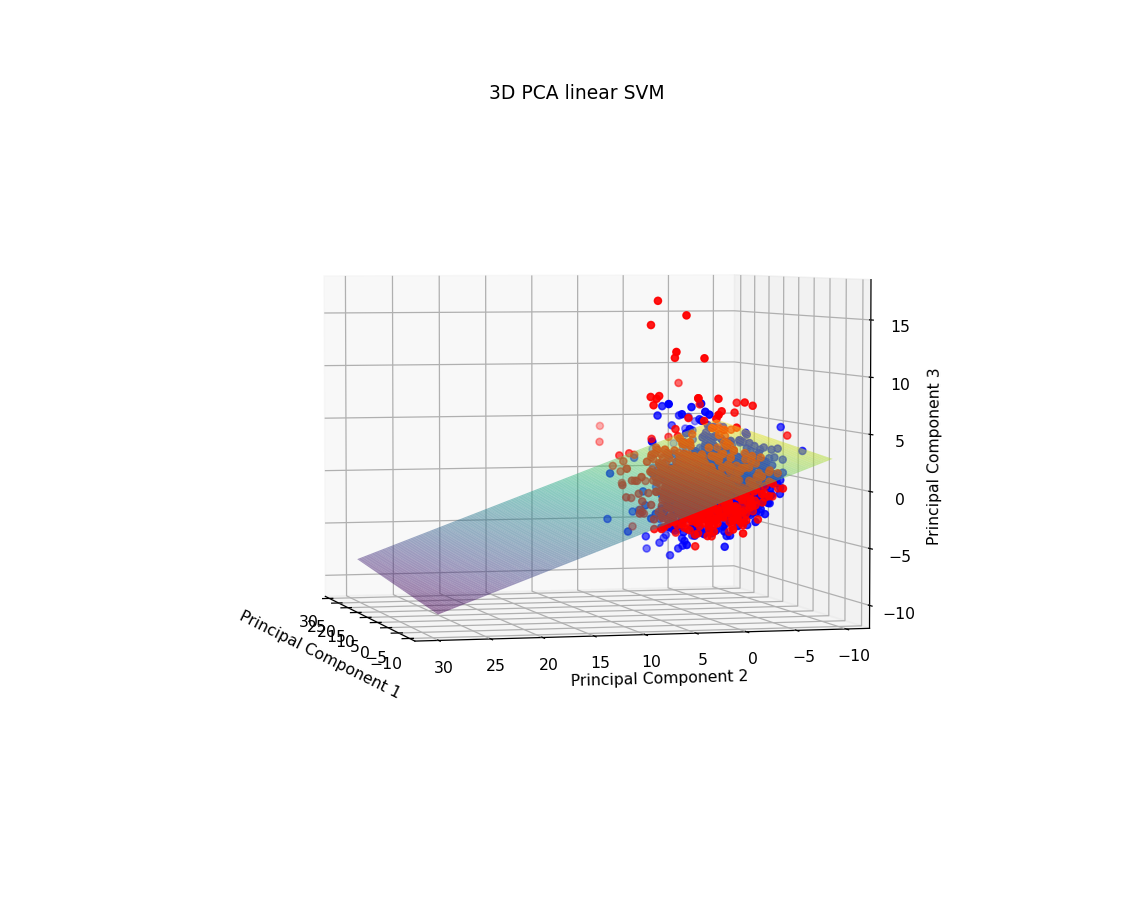

In [34]:
#PCA reduce to 2 and 3 dimensions then SVM linear
X1 = trainSpikeN.T
y1 = trainStateN.to_numpy()[0]

#2D
pcaData, pcaReduced = doPCA(X1, dimension = 2)
clf = svm.SVC(kernel='poly', degree=1)
clf.fit(pcaData, y1)
plotModel(pcaData, '2D PCA linear SVM', y = y1, boundary = clf)

#3D
pcaData, pcaReduced = doPCA(X1, dimension = 3)
clf = svm.SVC(kernel='linear')
clf.fit(pcaData, y1)
plotModel3D(pcaData, '3D PCA linear SVM', y = y1, boundary = clf)

<IPython.core.display.Javascript object>


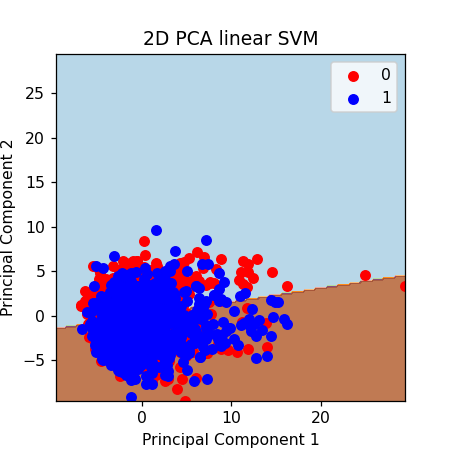

<IPython.core.display.Javascript object>


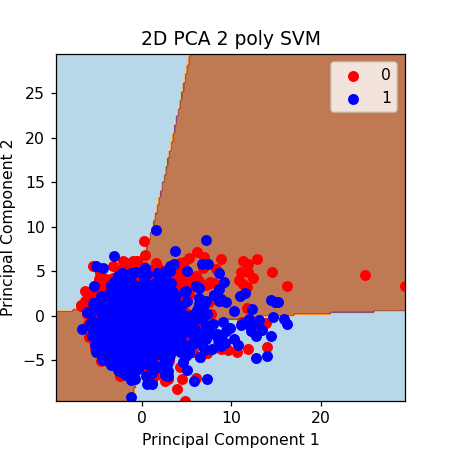

<IPython.core.display.Javascript object>


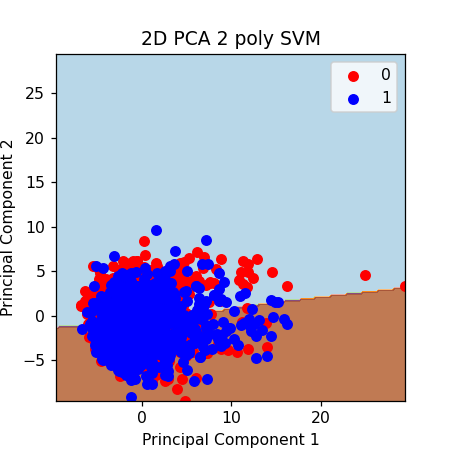

<IPython.core.display.Javascript object>


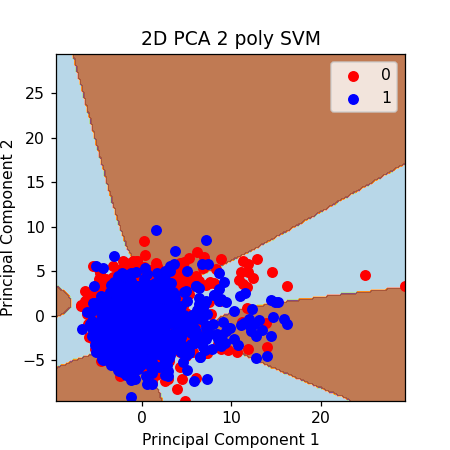

In [35]:
#PCA reduce to 2 dimensions then SVM with different kernels
X1 = trainSpikeN.T
y1 = trainStateN.to_numpy()[0]

#linear
pcaData, pcaReduced = doPCA(X1, dimension = 2)
clf = svm.SVC(kernel='poly', degree=1)
clf.fit(pcaData, y1)
plotModel(pcaData, '2D PCA linear SVM', y = y1, boundary = clf, sizeOfFig = (4,4))

#degree 2 poly
pcaData, pcaReduced = doPCA(X1, dimension = 2)
clf = svm.SVC(kernel='poly', degree=2)
clf.fit(pcaData, y1)
plotModel(pcaData, '2D PCA 2 poly SVM', y = y1, boundary = clf, sizeOfFig = (4,4))

#degree 3 poly
pcaData, pcaReduced = doPCA(X1, dimension = 2)
clf = svm.SVC(kernel='poly', degree=3)
clf.fit(pcaData, y1)
plotModel(pcaData, '2D PCA 2 poly SVM', y = y1, boundary = clf, sizeOfFig = (4,4))

#degree 4 poly
pcaData, pcaReduced = doPCA(X1, dimension = 2)
clf = svm.SVC(kernel='poly', degree=4)
clf.fit(pcaData, y1)
plotModel(pcaData, '2D PCA 2 poly SVM', y = y1, boundary = clf, sizeOfFig = (4,4))

In [36]:
def getRolling(X, y=[None], window = 2):
    rollingX = [X[i:i+window].to_numpy().flatten() for i in range(len(X) - window+1)]
    if y[0] == None:
        return rollingX
    else:
        rollingY = y[window-1:]
        return rollingX, rollingY



<IPython.core.display.Javascript object>


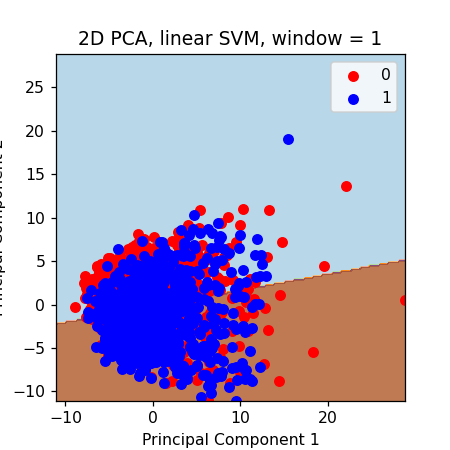

<IPython.core.display.Javascript object>


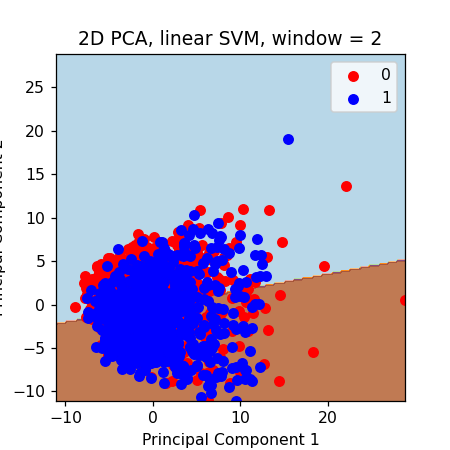

<IPython.core.display.Javascript object>


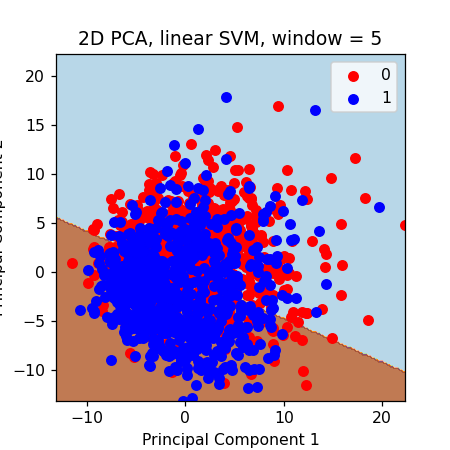

<IPython.core.display.Javascript object>


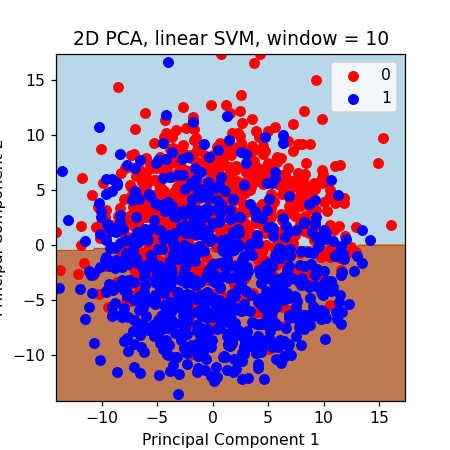

<IPython.core.display.Javascript object>


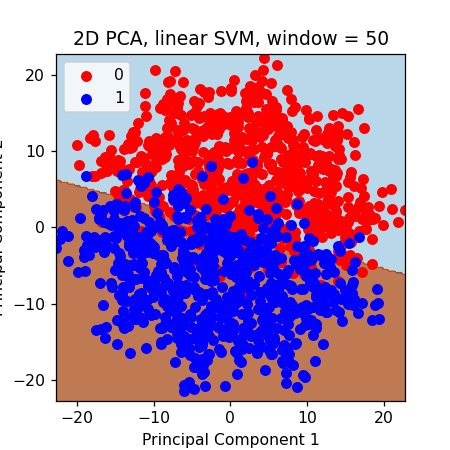

<IPython.core.display.Javascript object>


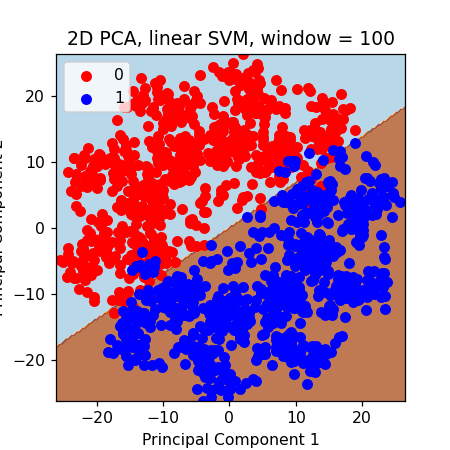

<IPython.core.display.Javascript object>


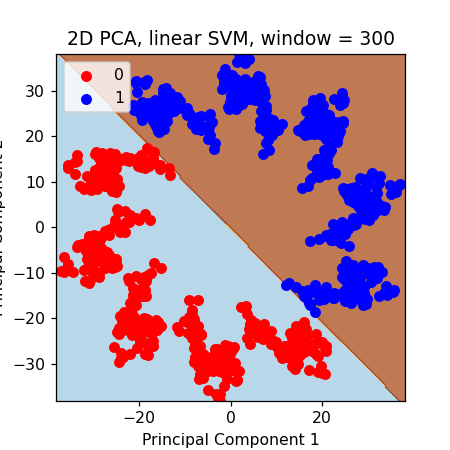

In [41]:
#Roll on different size windows, 
# PCA reduce to 2 dimensions ,
# SVM with linear kernel
X1 = trainSpikeN.T
y1 = trainStateN.to_numpy()[0]

#window = 1
XRolling, YRolling = getRolling(X1, y1, 2)

pcaData, pcaReduced = doPCA(XRolling, dimension = 2)
clf = svm.SVC(kernel='poly', degree=1)
clf.fit(pcaData, YRolling)
plotModel(pcaData, '2D PCA, linear SVM, window = 1', y = YRolling, boundary = clf, sizeOfFig = (4,4))

#window = 2
XRolling, YRolling = getRolling(X1, y1, 2)

pcaData, pcaReduced = doPCA(XRolling, dimension = 2)
clf = svm.SVC(kernel='poly', degree=1)
clf.fit(pcaData, YRolling)
plotModel(pcaData, '2D PCA, linear SVM, window = 2', y = YRolling, boundary = clf, sizeOfFig = (4,4))

#window = 5
XRolling, YRolling = getRolling(X1, y1, 5)

pcaData, pcaReduced = doPCA(XRolling, dimension = 2)
clf = svm.SVC(kernel='poly', degree=1)
clf.fit(pcaData, YRolling)
plotModel(pcaData, '2D PCA, linear SVM, window = 5', y = YRolling, boundary = clf, sizeOfFig = (4,4))

#window = 10
XRolling, YRolling = getRolling(X1, y1, 10)

pcaData, pcaReduced = doPCA(XRolling, dimension = 2)
clf = svm.SVC(kernel='poly', degree=1)
clf.fit(pcaData, YRolling)
plotModel(pcaData, '2D PCA, linear SVM, window = 10', y = YRolling, boundary = clf, sizeOfFig = (4,4))

#window = 50
XRolling, YRolling = getRolling(X1, y1, 50)

pcaData, pcaReduced = doPCA(XRolling, dimension = 2)
clf = svm.SVC(kernel='poly', degree=1)
clf.fit(pcaData, YRolling)
plotModel(pcaData, '2D PCA, linear SVM, window = 50', y = YRolling, boundary = clf, sizeOfFig = (4,4))

#window = 100
XRolling, YRolling = getRolling(X1, y1, 100)

pcaData, pcaReduced = doPCA(XRolling, dimension = 2)
clf = svm.SVC(kernel='poly', degree=1)
clf.fit(pcaData, YRolling)
plotModel(pcaData, '2D PCA, linear SVM, window = 100', y = YRolling, boundary = clf, sizeOfFig = (4,4))

#window = 300
XRolling, YRolling = getRolling(X1, y1, 300)

pcaData, pcaReduced = doPCA(XRolling, dimension = 2)
clf = svm.SVC(kernel='poly', degree=1)
clf.fit(pcaData, YRolling)
plotModel(pcaData, '2D PCA, linear SVM, window = 300', y = YRolling, boundary = clf, sizeOfFig = (4,4))

<h2>Parameter exploration</h2>

In [42]:
#Separate data in order to assess
split = [0.7, 0.2, 0.1]#Train, Validation, Test
Train_indices = int(split[0] * len(trainSpikeN.T))
Val_indices = int(sum(split[:2]) * len(trainSpikeN.T))
Test_indices = int(sum(split[:3]) * len(trainSpikeN.T))

trainSpikeNTrain = trainSpikeN.T[:Train_indices].T
trainSpikeNVal = trainSpikeN.T[Train_indices:Val_indices].T
trainSpikeNTest = trainSpikeN.T[Val_indices:Test_indices].T

trainStateNTrain = trainStateN.to_numpy()[0, :Train_indices]
trainStateNVal = trainStateN.to_numpy()[0, Train_indices:Val_indices]
trainStateNTest = trainStateN.to_numpy()[0, Val_indices:Test_indices]

In [66]:
#Define metrics functions
def metricsCalc(y, testState):

    # Initialize counters
    tp = fp = fn = tn = 0

    # Iterate over actual and predicted values
    for a, p in zip(testState, y):
        if a == 1 and p == 1:  # True Positive
            tp += 1
        elif a == 0 and p == 1:  # False Positive
            fp += 1
        elif a == 1 and p == 0:  # False Negative
            fn += 1
        elif a == 0 and p == 0:  # True Negative
            tn += 1

    pop = len(testState)

    confusionMatrix = pd.DataFrame([[tp, fn], [fp, tn]], index=['Actual Positive', 'Actual Negative'], columns=['Predicted Positive', 'Predicted Negative'])
    
    #Calculate results
    if pop == 0 :
        accuracy = 1
    else:
        accuracy = (tp+tn)/pop
        
    if (tp+fp) == 0 :
        precision = 1
    else:
        precision = tp/(tp+fp)
        
    if (tp+fn) == 0 :
        sensitivity = 1
    else:
        sensitivity = tp/(tp+fn)

    return accuracy, precision, sensitivity, confusionMatrix

def metricsPlot(metricResult, title = ''):
    plt.figure(figsize=(10, 8))
    accuracy = np.asarray(metricResult)[:,0]
    precision = np.asarray(metricResult)[:,1]
    sensitivity = np.asarray(metricResult)[:,2]
    
    xa = np.linspace(1, len(accuracy), len(accuracy))
    xp = np.linspace(1, len(precision), len(precision))
    xs = np.linspace(1, len(sensitivity), len(sensitivity))
    
    plt.plot(xa, accuracy, label='Accuracy')
    plt.plot(xp, precision, label='Precision')
    plt.plot(xs, sensitivity, label='Sensitivity')

    plt.xlabel('n')
    plt.ylabel('Metric value')
    plt.title('Metrics ' + title)
    plt.legend()
    
    plt.show()
    
def plotHeatMap(data, axisLabels, title = ''):
    labels = ['Accuracy', 'Precision', 'Sensitivity']
    fig, ax = plt.subplots(1, 3)
    fig.suptitle(title)
        
    #fig.setp(axisLabels)

    for i in range(3):
        ax[i].imshow(data[:, :, i], cmap='Greens')
        
        #tests = plt.annotate_heatmap(im, axisLabels[0], axisLabels[1], valfmt="{x:.1f} t")
        ax[i].set_title(labels[i])
        
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0,1), cmap ='Greens'), ax=ax)

In [46]:
#Grid search

#Set the range for the search
#degree, history, dimension of reduction
searchDimensions = [list(range(1, 6)), [1, 2, 3, 4], [1, 2, 3, 4, 5, 6, 7]]
#results = np.empty([len(searchDimensions[0]), len(searchDimensions[1])])
metricResult = np.empty([len(searchDimensions[0]), len(searchDimensions[1]), len(searchDimensions[2]), 3])
clfResult = np.empty([len(searchDimensions[0]), len(searchDimensions[1]), len(searchDimensions[2])], dtype=object)

for i, d in enumerate(searchDimensions[0]):
    for j, w in enumerate(searchDimensions[1]):
        for k, n in enumerate(searchDimensions[2]):
            #get data
            Xtrain, ytrain = getRolling(trainSpikeNTrain.T, trainStateNTrain.T, w)
            Xval, yval = getRolling(trainSpikeNVal.T, trainStateNVal.T, w)

            #PCA
            Xtrain, pca_ND = doPCA(Xtrain, dimension = n)
            Xval = pca_ND.transform(Xval)


            #fit model        
            clf = svm.SVC(kernel='poly', degree=d)
            clf.fit(Xtrain, ytrain)

            #test model
            #print(clf.predict(Xval))
            #results[i,j] = clf.predict(Xval)
            #Store result
            
            clfResult[i, j, k] = clf
            metricResult[i, j, k] = metricsCalc(clf.predict(Xval), yval)
    

<IPython.core.display.Javascript object>


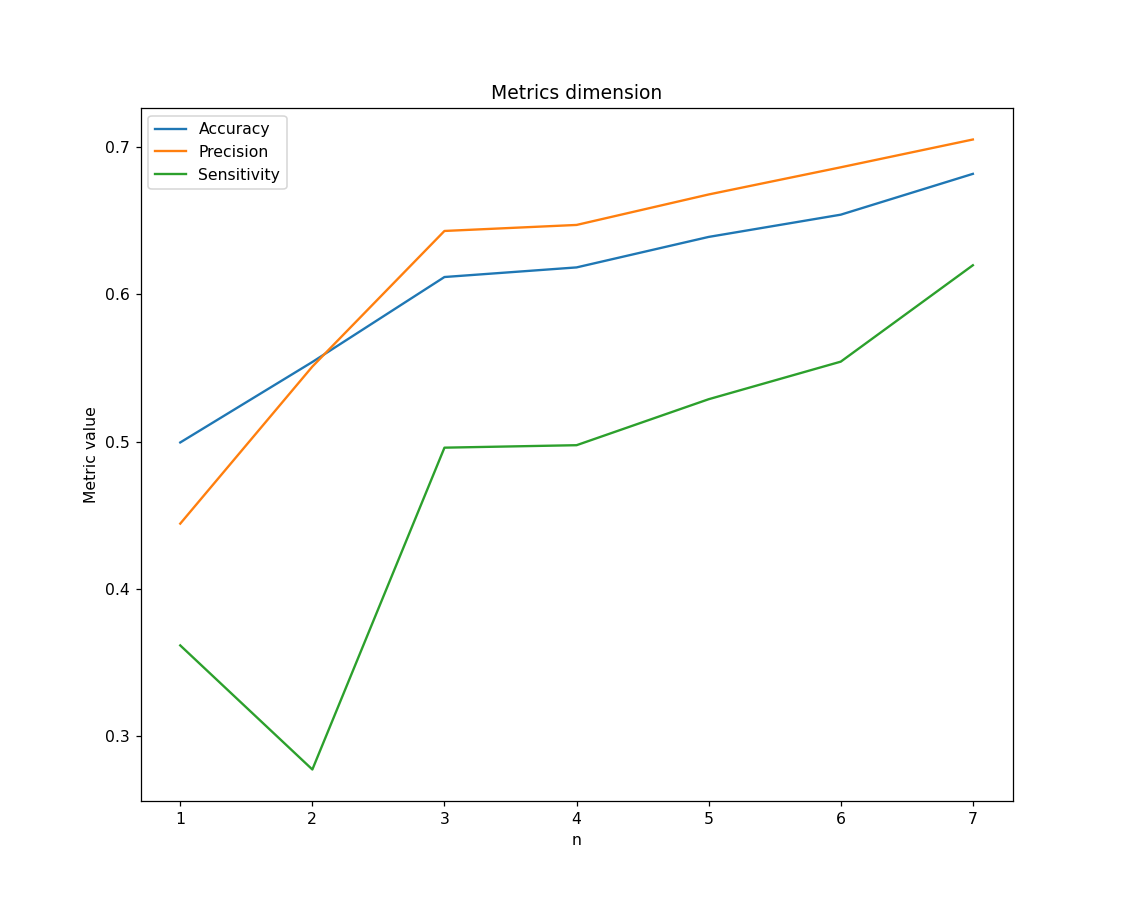

In [50]:
#Plot average values on 1D

#history
metricsPlot(np.average(np.average(metricResult, axis = 1), axis = 1), title = 'history')
#degree
metricsPlot(np.average(np.average(metricResult, axis = 0), axis = 1), title = 'degree')
#dimension
metricsPlot(np.average(np.average(metricResult, axis = 0), axis = 0), title = 'dimension')

<IPython.core.display.Javascript object>


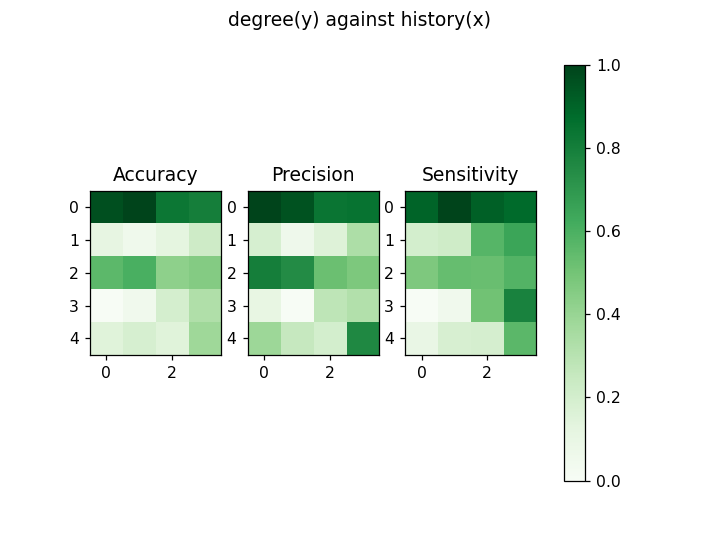

In [56]:
#plot avegare heatmaps
#history against dimension
plotHeatMap(np.average(metricResult, axis = 0), axisLabels = searchDimensions[1:], title = 'history(y) against dimension(x)')
#degree against dimension
plotHeatMap(np.average(metricResult, axis = 1), axisLabels = [searchDimensions[0], searchDimensions[2]], title = 'degree(y) against dimension(x)')
#degree against history
plotHeatMap(np.average(metricResult, axis = 2), axisLabels = searchDimensions[:2], title = 'degree(y) against history(x)')

<IPython.core.display.Javascript object>


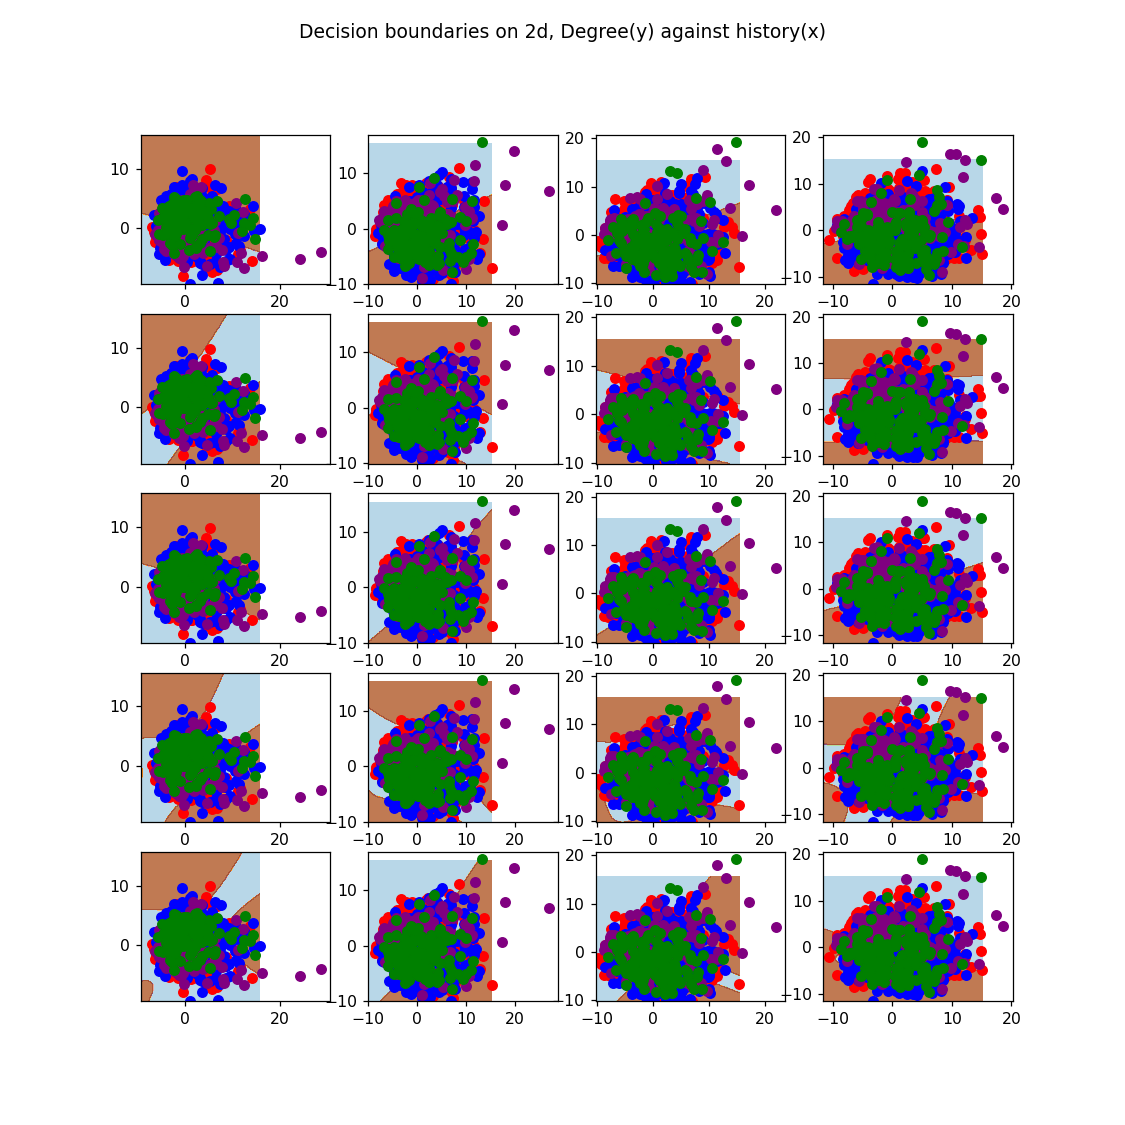

In [58]:
#plot grid of decision boundaries on 2d
fig, ax = plt.subplots(len(searchDimensions[0]), len(searchDimensions[1]),\
                       figsize = (10,10))
fig.suptitle('Decision boundaries on 2d, Degree(y) against history(x)')

n = 2

#fig.setp(axisLabels)
for i, d in enumerate(searchDimensions[0]):
    for j, w in enumerate(searchDimensions[1]):
        #get data
        Xtrain, ytrain = getRolling(trainSpikeNTrain.T, trainStateNTrain.T, w)
        Xval, yval = getRolling(trainSpikeNVal.T, trainStateNVal.T, w)

        #PCA
        Xtrain, pca_ND = doPCA(Xtrain, dimension = n)
        Xval = pca_ND.transform(Xval)


        #fit model        
        clf = svm.SVC(kernel='poly', degree=d)
        clf.fit(Xtrain, ytrain)
        
        plotModel(Xtrain, y = ytrain, boundary = clf, sizeOfFig = (4,4),\
                  Xval = Xval, yval = yval, ax = ax[i, j])
        #ax[i].set_title(labels[i])
        


<h2>Performance on the training data</h2>

In [59]:
#Manually choose values
bestIndicies = (2,3,1)
bestValues = [searchDimensions[i][j] for i, j in enumerate(bestIndicies)]
print('best values are:')
print('degree:', bestValues[0])
print('history:', bestValues[1])
print('dimension:', bestValues[2])

best values are:
degree: 3
history: 4
dimension: 2


In [73]:
#Assess final model on test data
d, w, n = bestValues

#get data
Xtrain, ytrain = getRolling(trainSpikeNTrain.T, trainStateNTrain.T, w)
Xval, yval = getRolling(trainSpikeNVal.T, trainStateNVal.T, w)
XTest, ytest = getRolling(trainSpikeNTest.T, trainStateNTest.T, w)

#PCA
Xtrain, pca_ND = doPCA(Xtrain, dimension = n)
Xval = pca_ND.transform(Xval)
XTest = pca_ND.transform(XTest)


#fit model        
clfFinal = svm.SVC(kernel='poly', degree=d)
clfFinal.fit(Xtrain, ytrain)

#test model
valResults = metricsCalc(clfFinal.predict(Xval), yval)
testResults = metricsCalc(clfFinal.predict(XTest), ytest)
#for row in confusionMatrix:
#        print(row)

print('validation accuracy:', valResults[0])
print('validation precision:', valResults[1])
print('validation sensitivity:', valResults[2])

print('test accuracy:', testResults[0])
print('test precision:', testResults[1])
print('test sensitivity:', testResults[2])

print('Confusion matrix for test')
testResults[3]

validation accuracy: 0.597972972972973
validation precision: 0.65625
validation sensitivity: 0.4228187919463087
test accuracy: 0.7278911564625851
test precision: 0.7931034482758621
test sensitivity: 0.6216216216216216
Confusion matrix for test


,Predicted Positive,Predicted Negative
Actual Positive,46,28
Actual Negative,12,61


<h2>Final result<h2>

In [61]:
d, w, n = bestValues

#get data
testRolling = getRolling(testSpike.T, window = w)

#PCA
Xtest, pca_ND = doPCA(testRolling, dimension = n)

#Predict

Ytest = clfFinal.predict(Xtest)

#undo rolling
Ytest = np.concatenate((np.zeros(w-1), Ytest))

metricscalc

In [62]:
#Save to mat
mdict = {'decodedState': Ytest,
        'label': 'decodedState'}
scipy.io.savemat('result.mat', mdict)